In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-match-probability-prediction/sample_submission.csv
/kaggle/input/football-match-probability-prediction/train_target_and_scores.csv
/kaggle/input/football-match-probability-prediction/train.csv
/kaggle/input/football-match-probability-prediction/test.csv


In [2]:
#import modules
from sklearn import metrics, model_selection
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

#loading the data
train = pd.read_csv('/kaggle/input/football-match-probability-prediction/train.csv')
test = pd.read_csv('/kaggle/input/football-match-probability-prediction/test.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    df.is_cup = df.is_cup.apply(lambda x: np.multiply(x, 1) )
    df['is_cup'].fillna(0, inplace=True) # missing value filled with 0, ie non-cup game
    return df

In [4]:
def has_coach_change(df):
    '''add features indicating whether home and away teams have changed coach'''
    
    df['home_has_coach_change'] = df.apply(lambda r: any([(r['home_team_coach_id']!=r[f'home_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'home_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['home_has_coach_change'] = df['home_has_coach_change'].apply(lambda x: np.multiply(x, 1) )
    df['home_has_coach_change'].fillna(0, inplace=True)
    df['away_has_coach_change'] = df.apply(lambda r: any([(r['away_team_coach_id']!=r[f'away_team_history_coach_{i}']) 
                                                    & (np.isnan(r[f'away_team_history_coach_{i}'])==False) for i in range(1,11) ]) , axis=1)
    df['away_has_coach_change'] = df['away_has_coach_change'].apply(lambda x: np.multiply(x, 1) ).fillna(0, inplace=True)
    df['away_has_coach_change'].fillna(0, inplace=True)
    return df

In [5]:
feature_columns = ['id', 'match_date','league_id','is_cup','home_team_coach_id','away_team_coach_id','home_has_coach_change','away_has_coach_change']
history_columns = [col for col in train.columns if col[-1].isdigit()]

In [6]:
def convert_to_long_form(df, feature_columns, history_columns):
    '''coverting the history columns into long form, for convenience and better speed of manipulation'''
    stubname=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id',
           'away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']
    df_long=pd.wide_to_long(df[feature_columns+history_columns], stubnames=stubname, i='id', j='match', sep='_')
    df_long=df_long.reset_index().sort_values(by=['id','match'])
    return df_long

In [7]:
#train2= is_cup_conversion(train)

In [8]:
#train2 = has_coach_change(train2)

In [9]:
#train2

In [10]:
#train2.away_has_coach_change.isnull().value_counts()

In [11]:
#train2=convert_to_long_form(train2, feature_columns, history_columns)

In [12]:
#train2

In [13]:
def add_match_interval(df):
    '''add features indicating the time gaps between the match days of previous matches for the home and away teams, 
    and how long they played 3 matches and 6 matches,as an reflection of fatique factor'''
    for i in [1,2,5]:
        home_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').home_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(home_team_history_match_interval.to_frame(name=f'home_team_history_match_interval_{i}'), on='id')
        
        away_team_history_match_interval = (df.groupby('id').match_date.first().apply(pd.Timestamp) \
             - df.query('match ==1').groupby('id').away_team_history_match_date.first().apply(pd.Timestamp) ) /np.timedelta64(1, "D")
        df=df.join(away_team_history_match_interval.to_frame(name=f'away_team_history_match_interval_{i}'), on='id')
        
    return df

In [14]:
#train2 = add_match_interval(train2)

In [15]:
#train2

In [16]:
#train2.away_team_history_match_interval_5.isnull().value_counts()

In [17]:
def get_median(a):
    if a.size == 0 or all(np.isnan(a)):
        return np.NaN
    else:
        return np.nanmedian(a)

In [18]:
def result_point(goal_difference):
    if goal_difference > 0:
        return 3
    elif goal_difference==0:
        return 1
    elif goal_difference < 0:
        return 0
    else:
        return np.NaN

In [19]:
def add_form_features(df):
    '''adding form features for home and away teams, including rating difference and goal difference for each previous match,
    and the average points got, average goal scored, average goal conceded and average goal difference up to that match as previous n-match form'''
    
    df['home_team_history_goal_difference']=df['home_team_history_goal']-df['home_team_history_opponent_goal']
    df['away_team_history_goal_difference']=df['away_team_history_goal']-df['away_team_history_opponent_goal']
    df['home_team_history_point']=df.home_team_history_goal_difference.apply(result_point)
    df['away_team_history_point']=df.away_team_history_goal_difference.apply(result_point)
    df['home_team_history_rating_difference']=df['home_team_history_rating']-df['home_team_history_opponent_rating']
    df['away_team_history_rating_difference']=df['away_team_history_rating']-df['away_team_history_opponent_rating']
        
    for i in [5,10]:
        home_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').home_team_history_goal.mean()
        df=df.join(home_team_history_average_goal_scored.to_frame(name=f'home_team_history_average_goal_scored_{i}'), on='id')
        home_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').home_team_history_opponent_goal.mean()
        df=df.join(home_team_history_average_goal_conceded.to_frame(name=f'home_team_history_average_goal_conceded_{i}'), on='id')
        
        away_team_history_average_goal_scored=df.query(f'match <= {i}').groupby('id').away_team_history_goal.mean()
        df=df.join(away_team_history_average_goal_scored.to_frame(name=f'away_team_history_average_goal_scored_{i}'), on='id')
        away_team_history_average_goal_conceded=df.query(f'match <= {i}').groupby('id').away_team_history_opponent_goal.mean()
        df=df.join(away_team_history_average_goal_conceded.to_frame(name=f'away_team_history_average_goal_conceded_{i}'), on='id')
        
        df[f'home_team_history_average_goal_difference_{i}']=df[f'home_team_history_average_goal_scored_{i}']-df[f'home_team_history_average_goal_conceded_{i}']
        df[f'away_team_history_average_goal_difference_{i}']=df[f'away_team_history_average_goal_scored_{i}']-df[f'away_team_history_average_goal_conceded_{i}']
        
        home_team_history_average_point=df.query(f'match <= {i}').groupby('id').home_team_history_point.mean()
        df=df.join(home_team_history_average_point.to_frame(name=f'home_team_history_average_point_{i}'), on='id')
        away_team_history_average_point=df.query(f'match <= {i}').groupby('id').away_team_history_point.mean()
        df=df.join(away_team_history_average_point.to_frame(name=f'away_team_history_average_point_{i}'), on='id')
        home_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').home_team_history_point.std()
        df=df.join(home_team_history_average_point_std.to_frame(name=f'home_team_history_average_point_std_{i}'), on='id')
        away_team_history_average_point_std=df.query(f'match <= {i}').groupby('id').away_team_history_point.std()
        df=df.join(away_team_history_average_point_std.to_frame(name=f'away_team_history_average_point_std_{i}'), on='id')
        
        home_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.median()
        df=df.join(home_team_history_median_rating_difference.to_frame(name=f'home_team_history_median_rating_difference_{i}'), on='id')
        away_team_history_median_rating_difference=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.median()
        df=df.join(away_team_history_median_rating_difference.to_frame(name=f'away_team_history_median_rating_difference_{i}'), on='id')
        home_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').home_team_history_rating_difference.std()
        df=df.join(home_team_history_rating_difference_std.to_frame(name=f'home_team_history_rating_difference_std_{i}'), on='id')
        away_team_history_rating_difference_std=df.query(f'match <= {i}').groupby('id').away_team_history_rating_difference.std()
        df=df.join(away_team_history_rating_difference_std.to_frame(name=f'away_team_history_rating_difference_std_{i}'), on='id')
        
    return df

In [20]:
def add_attack_defense_strength_features(df):
    '''getting goal rates of the league/competition, and calculate the attack and defense strength of a team relative to the league/competition,
    and the expected goals base on this'''
    league_total_goal = df.groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + df.groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + df.groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + df.groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_game = df.groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + df.groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + df.groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + df.groupby('away_team_history_league_id').away_team_history_opponent_goal.count() 
    league_average_goal = league_total_goal/league_total_game
    df=df.join(league_average_goal.to_frame(name='league_average_goal'), on='league_id')
    df.league_average_goal.fillna(df.league_average_goal.mean(), inplace=True)
    
    league_total_home_goal = df.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + df.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + df.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + df.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_home_goal_game = df.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + df.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + df.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + df.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_home_goal = league_total_home_goal/league_total_home_goal_game
    df=df.join(league_average_home_goal.to_frame(name='league_average_home_goal'), on='league_id')
    
    league_total_away_goal = df.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.sum() \
                    + df.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.sum() \
                    + df.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.sum() \
                    + df.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.sum()
    league_total_away_goal_game = df.query('home_team_history_is_play_home==0').groupby('home_team_history_league_id').home_team_history_goal.count() \
                    + df.query('home_team_history_is_play_home==1').groupby('home_team_history_league_id').home_team_history_opponent_goal.count() \
                    + df.query('away_team_history_is_play_home==0').groupby('away_team_history_league_id').away_team_history_goal.count() \
                    + df.query('away_team_history_is_play_home==1').groupby('away_team_history_league_id').away_team_history_opponent_goal.count()
    league_average_away_goal = league_total_away_goal/league_total_away_goal_game
    df=df.join(league_average_away_goal.to_frame(name='league_average_away_goal'), on='league_id')
    
    df['home_team_attack_strength'] = df.home_team_history_average_goal_scored_10/df.league_average_goal
    df['home_team_defense_strength'] = df.home_team_history_average_goal_conceded_10/df.league_average_goal
    df['away_team_attack_strength'] = df.away_team_history_average_goal_scored_10/df.league_average_goal
    df['away_team_defense_strength'] = df.away_team_history_average_goal_conceded_10/df.league_average_goal
    df['home_team_expected_goal'] = df.league_average_home_goal*df.home_team_attack_strength*df.away_team_defense_strength
    df['away_team_expected_goal'] = df.league_average_away_goal*df.away_team_attack_strength*df.home_team_defense_strength
    
    return df

In [21]:
#train2=add_form_features(train2)

In [22]:
#train2=add_attack_defense_strength_features(train2)
#train2.groupby('league_id').league_average_home_goal.mean()

In [23]:
#train2

In [24]:
#train2.home_team_history_goal_difference.apply(result_point)

In [25]:
def preprocession(df):
    df=is_cup_conversion(df)
    df=has_coach_change(df)
    df=convert_to_long_form(df, feature_columns, history_columns)
    df=add_match_interval(df)
    df=add_form_features(df)
    df=add_attack_defense_strength_features(df)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

In [26]:
train_p=preprocession(train)

In [27]:
for i in train_p.columns:
    print(i, train_p.loc[467,i])

id 11978898
match 1
away_team_coach_id 37252510.0
home_has_coach_change 0
home_team_coach_id 37252510.0
away_has_coach_change 0
match_date 2019-12-01 15:00:00
is_cup 0.0
league_id 1475
home_team_history_match_date 2019-11-24 15:00:00
home_team_history_is_play_home 0.0
home_team_history_is_cup 0.0
home_team_history_goal 2.0
home_team_history_opponent_goal 0.0
home_team_history_rating 2.29951
home_team_history_opponent_rating 9.70657
home_team_history_coach 37252510.0
home_team_history_league_id 1475.0
away_team_history_match_date 2019-11-24 15:00:00
away_team_history_is_play_home 1.0
away_team_history_is_cup 0.0
away_team_history_goal 0.0
away_team_history_opponent_goal 1.0
away_team_history_rating 6.92024
away_team_history_opponent_rating 2.8847
away_team_history_coach 37252510.0
away_team_history_league_id 1475.0
home_team_history_match_interval_1 7.0
away_team_history_match_interval_1 7.0
home_team_history_match_interval_2 7.0
away_team_history_match_interval_2 7.0
home_team_history_

In [28]:
#train_p.fillna(train_p.mean(), inplace=True)

In [29]:
train_p=train_p.groupby('id').first().reset_index()

In [30]:
train_p

,id,match,away_team_coach_id,home_has_coach_change,home_team_coach_id,away_has_coach_change,match_date,is_cup,league_id,home_team_history_match_date,...,away_team_history_rating_difference_std_10,league_average_goal,league_average_home_goal,league_average_away_goal,home_team_attack_strength,home_team_defense_strength,away_team_attack_strength,away_team_defense_strength,home_team_expected_goal,away_team_expected_goal
0,11428294,1,257433.0,1,468693.0,0,2019-12-03 23:00:00,0.0,755,2019-11-27 21:00:00,...,2.884664,1.328327,1.378733,1.277922,0.451696,0.752827,0.526979,1.129240,0.703254,0.506981
1,11428295,1,16476269.0,1,37331516.0,0,2019-12-01 23:00:00,0.0,755,2019-11-27 23:00:00,...,2.824514,1.328327,1.378733,1.277922,1.731501,0.978674,1.355088,0.376413,0.898603,1.694767
2,11428297,1,474745.0,1,212710.0,0,2019-12-02 21:00:00,0.0,755,2019-11-28 23:00:00,...,2.530758,1.328327,1.378733,1.277922,0.978674,1.505653,0.677544,1.053957,1.422137,1.303667
3,11428298,1,472575.0,0,186127.0,0,2019-12-01 23:00:00,0.0,755,2019-11-27 21:00:00,...,2.827534,1.328327,1.378733,1.277922,0.526979,0.978674,1.279805,0.376413,0.273488,1.600613
4,11428299,1,216631.0,0,470514.0,0,2019-12-01 21:00:00,0.0,755,2019-11-28 21:00:00,...,2.780280,1.328327,1.378733,1.277922,1.204522,0.677544,0.828109,0.752827,1.250230,0.717017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,18045358,1,NaN,1,NaN,0,2021-04-29 18:00:00,0.0,827,2021-04-25 16:00:00,...,2.219175,1.095223,1.148263,1.042184,1.095667,0.913056,1.552195,0.730445,0.918983,1.477025
110934,18046139,1,1552546.0,1,37568493.0,0,2021-04-30 10:00:00,0.0,974,2021-03-04 12:15:00,...,3.224700,1.466866,1.564197,1.369535,1.295278,1.499796,1.908831,0.272690,0.552490,3.920785
110935,18046140,1,17905337.0,0,22859379.0,0,2021-04-30 13:00:00,0.0,974,2021-03-04 09:45:00,...,3.372524,1.466866,1.564197,1.369535,0.886243,1.295278,1.363451,0.818071,1.134058,2.418666
110936,18046141,1,2206663.0,1,29328646.0,0,2021-04-30 15:00:00,0.0,974,2021-03-05 10:00:00,...,3.759449,1.466866,1.564197,1.369535,0.409035,1.431624,1.158933,0.954416,0.610646,2.272273


In [31]:
match_date_columns=[col for col in train_p.columns if ('match_date' in col)]
match_date_columns

['match_date', 'home_team_history_match_date', 'away_team_history_match_date']

In [32]:
history_rating_columns=[col for col in train_p.columns if ((('history_rating' in col) | ('history_opponent_rating' in col)) & ('difference' not in col))]
history_rating_columns

['home_team_history_rating',
 'home_team_history_opponent_rating',
 'away_team_history_rating',
 'away_team_history_opponent_rating']

In [33]:
X=train_p.drop(match_date_columns, axis=1)
X=X.drop(['id','match'], axis=1)
y=train.sort_values(by='id')['target']
#X=X.drop(['id','home_team_name','away_team_name','league_name','target'], axis=1)
#y=train_p['target']

In [34]:
X

,away_team_coach_id,home_has_coach_change,home_team_coach_id,away_has_coach_change,is_cup,league_id,home_team_history_is_play_home,home_team_history_is_cup,home_team_history_goal,home_team_history_opponent_goal,...,away_team_history_rating_difference_std_10,league_average_goal,league_average_home_goal,league_average_away_goal,home_team_attack_strength,home_team_defense_strength,away_team_attack_strength,away_team_defense_strength,home_team_expected_goal,away_team_expected_goal
0,257433.0,1,468693.0,0,0.0,755,0.0,0.0,0.0,0.0,...,2.884664,1.328327,1.378733,1.277922,0.451696,0.752827,0.526979,1.129240,0.703254,0.506981
1,16476269.0,1,37331516.0,0,0.0,755,0.0,0.0,2.0,1.0,...,2.824514,1.328327,1.378733,1.277922,1.731501,0.978674,1.355088,0.376413,0.898603,1.694767
2,474745.0,1,212710.0,0,0.0,755,0.0,0.0,0.0,1.0,...,2.530758,1.328327,1.378733,1.277922,0.978674,1.505653,0.677544,1.053957,1.422137,1.303667
3,472575.0,0,186127.0,0,0.0,755,0.0,0.0,0.0,1.0,...,2.827534,1.328327,1.378733,1.277922,0.526979,0.978674,1.279805,0.376413,0.273488,1.600613
4,216631.0,0,470514.0,0,0.0,755,0.0,0.0,3.0,0.0,...,2.780280,1.328327,1.378733,1.277922,1.204522,0.677544,0.828109,0.752827,1.250230,0.717017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110933,NaN,1,NaN,0,0.0,827,1.0,0.0,0.0,1.0,...,2.219175,1.095223,1.148263,1.042184,1.095667,0.913056,1.552195,0.730445,0.918983,1.477025
110934,1552546.0,1,37568493.0,0,0.0,974,0.0,0.0,1.0,2.0,...,3.224700,1.466866,1.564197,1.369535,1.295278,1.499796,1.908831,0.272690,0.552490,3.920785
110935,17905337.0,0,22859379.0,0,0.0,974,0.0,0.0,0.0,5.0,...,3.372524,1.466866,1.564197,1.369535,0.886243,1.295278,1.363451,0.818071,1.134058,2.418666
110936,2206663.0,1,29328646.0,0,0.0,974,0.0,0.0,0.0,4.0,...,3.759449,1.466866,1.564197,1.369535,0.409035,1.431624,1.158933,0.954416,0.610646,2.272273


In [35]:
#X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [36]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [37]:
from sklearn import model_selection
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, label_encoded_y, train_size=0.8, random_state=42)

In [38]:
import xgboost as xgb
d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_valid, y_valid)

In [39]:
params_1 = {
    'booster': 'gbtree',
    'max_depth': 5, 
    'learning_rate': 0.05,
    'min_split_loss': 0.01,
    'min_child_weight': 5,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'alpha': 1,
    'lambda': 1,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

num_round = 500
evallist = [(d_train, 'train'), (d_test, 'eval')]

In [40]:
bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=10)

[0]	train-mlogloss:1.09282	eval-mlogloss:1.09324
[1]	train-mlogloss:1.08720	eval-mlogloss:1.08800
[2]	train-mlogloss:1.08224	eval-mlogloss:1.08334
[3]	train-mlogloss:1.07767	eval-mlogloss:1.07911
[4]	train-mlogloss:1.07331	eval-mlogloss:1.07513
[5]	train-mlogloss:1.06940	eval-mlogloss:1.07160
[6]	train-mlogloss:1.06557	eval-mlogloss:1.06810
[7]	train-mlogloss:1.06201	eval-mlogloss:1.06491
[8]	train-mlogloss:1.05869	eval-mlogloss:1.06193
[9]	train-mlogloss:1.05541	eval-mlogloss:1.05891
[10]	train-mlogloss:1.05255	eval-mlogloss:1.05636
[11]	train-mlogloss:1.04981	eval-mlogloss:1.05389
[12]	train-mlogloss:1.04730	eval-mlogloss:1.05166
[13]	train-mlogloss:1.04472	eval-mlogloss:1.04937
[14]	train-mlogloss:1.04233	eval-mlogloss:1.04729
[15]	train-mlogloss:1.04004	eval-mlogloss:1.04536
[16]	train-mlogloss:1.03788	eval-mlogloss:1.04346
[17]	train-mlogloss:1.03586	eval-mlogloss:1.04172
[18]	train-mlogloss:1.03387	eval-mlogloss:1.04009
[19]	train-mlogloss:1.03207	eval-mlogloss:1.03859
[20]	train

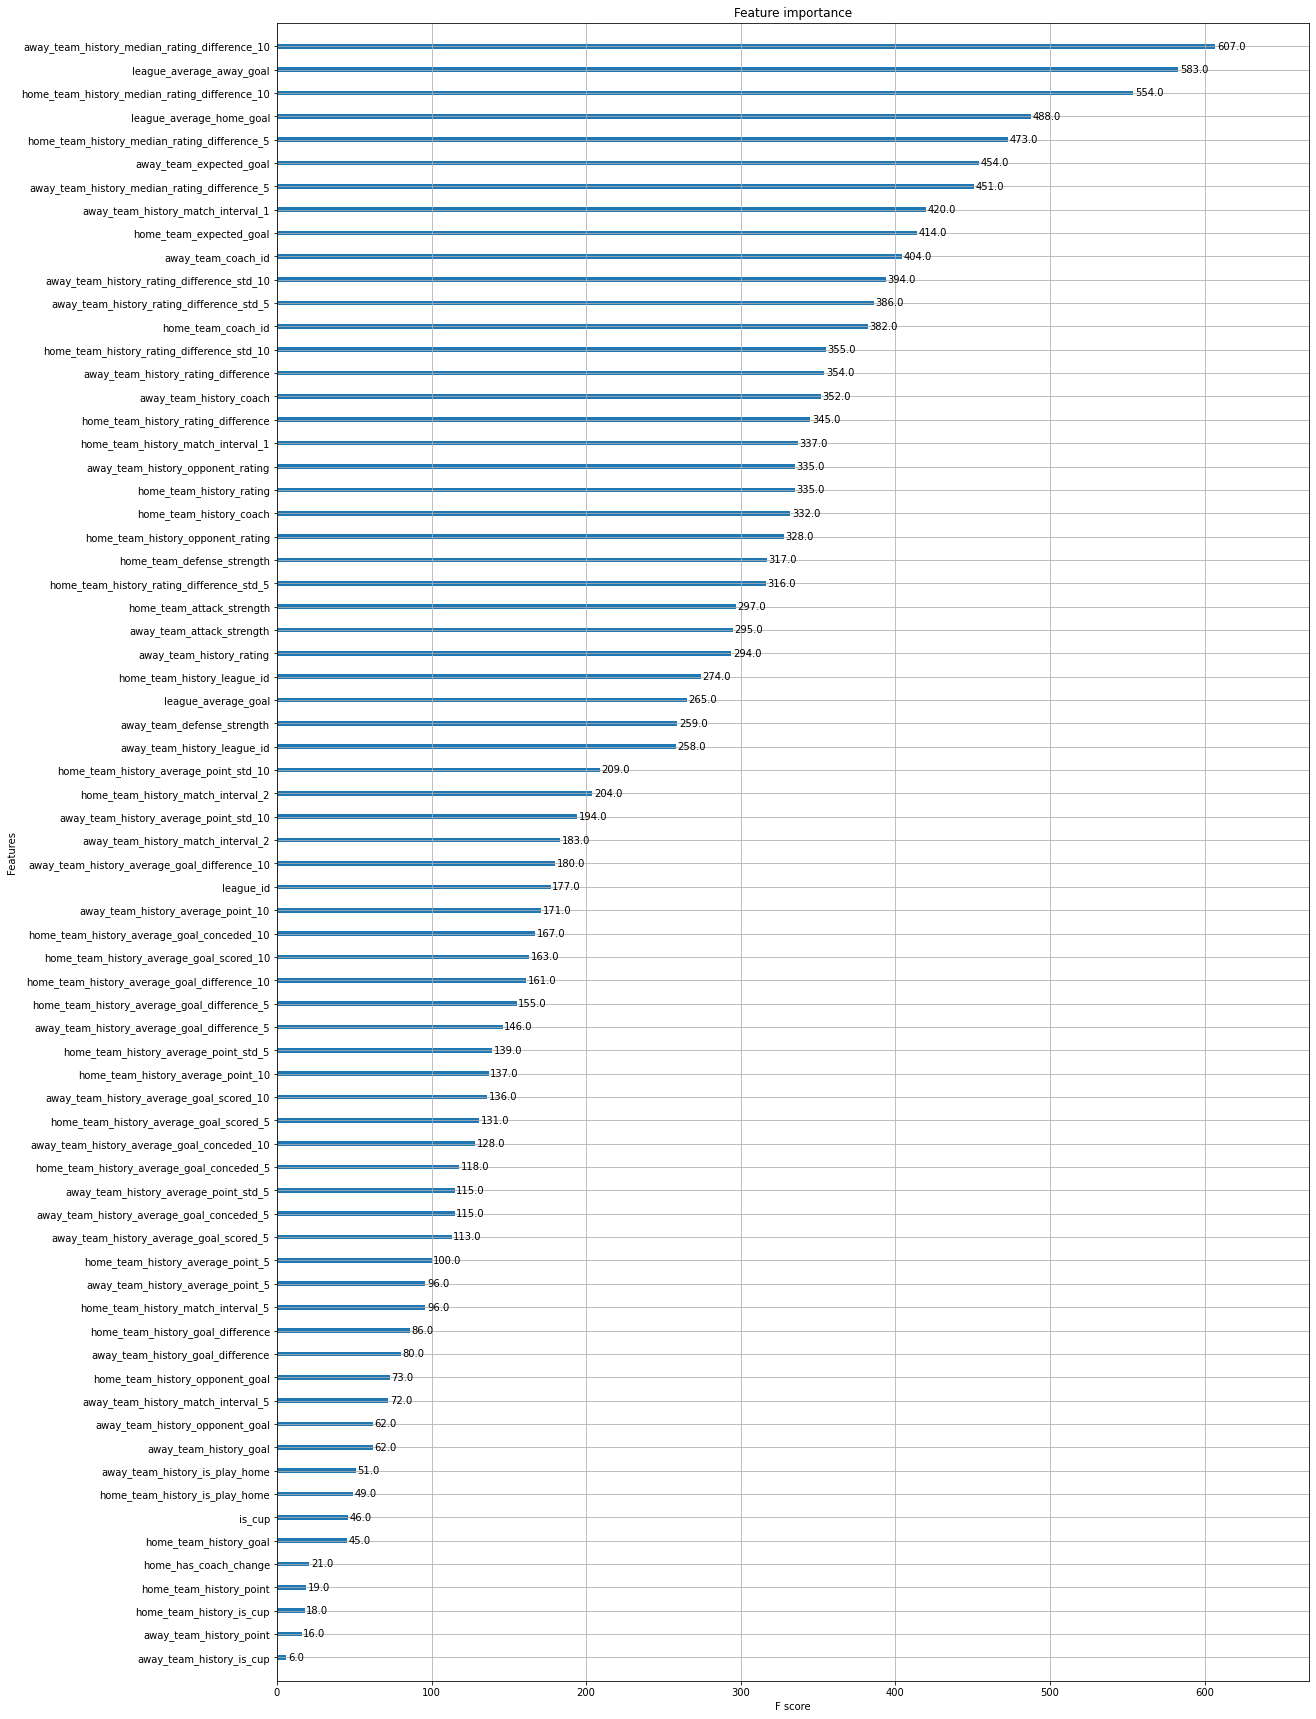

In [41]:
xgb.plot_importance(bst, max_num_features=200)
fig = plt.gcf()
fig.set_size_inches(18.5, 30.5)

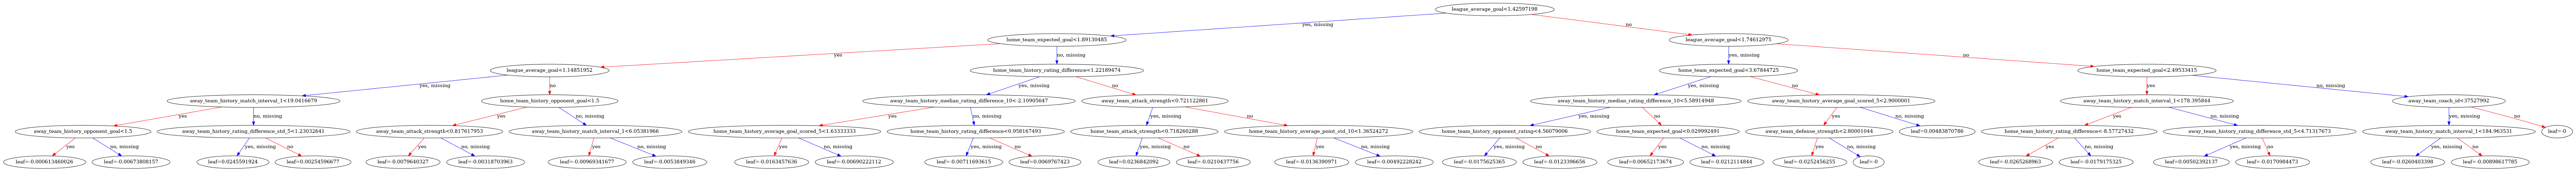

In [42]:
xgb.plot_tree(bst, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(160, 100)

In [43]:
bst.best_iteration

175

In [44]:
bst.best_score

1.011726

In [45]:
test_p=preprocession(test)

In [46]:
test_p

,id,match,away_team_coach_id,home_has_coach_change,home_team_coach_id,away_has_coach_change,match_date,is_cup,league_id,home_team_history_match_date,...,away_team_history_rating_difference_std_10,league_average_goal,league_average_home_goal,league_average_away_goal,home_team_attack_strength,home_team_defense_strength,away_team_attack_strength,away_team_defense_strength,home_team_expected_goal,away_team_expected_goal
11774,11913628,1,1565666.0,1,37570473.0,0,2021-06-07 14:00:00,1,714,2021-05-30 11:30:00,...,7.483509,1.615560,1.900391,1.330729,0.541608,2.089059,1.299859,0.804675,0.828225,3.613571
84485,11913628,2,1565666.0,1,37570473.0,0,2021-06-07 14:00:00,1,714,2019-11-19 11:00:00,...,7.483509,1.615560,1.900391,1.330729,0.541608,2.089059,1.299859,0.804675,0.828225,3.613571
157196,11913628,3,1565666.0,1,37570473.0,0,2021-06-07 14:00:00,1,714,2019-10-15 14:00:00,...,7.483509,1.615560,1.900391,1.330729,0.541608,2.089059,1.299859,0.804675,0.828225,3.613571
229907,11913628,4,1565666.0,1,37570473.0,0,2021-06-07 14:00:00,1,714,2019-10-10 12:00:00,...,7.483509,1.615560,1.900391,1.330729,0.541608,2.089059,1.299859,0.804675,0.828225,3.613571
302618,11913628,5,1565666.0,1,37570473.0,0,2021-06-07 14:00:00,1,714,2019-09-10 05:30:00,...,7.483509,1.615560,1.900391,1.330729,0.541608,2.089059,1.299859,0.804675,0.828225,3.613571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435926,18450641,6,37572009.0,0,261421.0,0,2021-11-28 22:30:00,0,779,2021-10-21 00:00:00,...,2.539064,1.391041,1.640372,1.141710,1.150217,0.718886,1.006440,0.718886,1.356383,0.826045
508637,18450641,7,37572009.0,0,261421.0,0,2021-11-28 22:30:00,0,779,2021-10-16 17:00:00,...,2.539064,1.391041,1.640372,1.141710,1.150217,0.718886,1.006440,0.718886,1.356383,0.826045
581348,18450641,8,37572009.0,0,261421.0,0,2021-11-28 22:30:00,0,779,2021-10-10 00:00:00,...,2.539064,1.391041,1.640372,1.141710,1.150217,0.718886,1.006440,0.718886,1.356383,0.826045
654059,18450641,9,37572009.0,0,261421.0,0,2021-11-28 22:30:00,0,779,2021-10-03 20:00:00,...,2.539064,1.391041,1.640372,1.141710,1.150217,0.718886,1.006440,0.718886,1.356383,0.826045


In [47]:
test_p=test_p.groupby('id').first().reset_index()
X_test=test_p.drop(match_date_columns, axis=1)
X_test=X_test.drop(['id','match'], axis=1)
#X_test=X_test.drop(['id','home_team_name','away_team_name','league_name'], axis=1)
X_test_d = xgb.DMatrix(X_test)

In [48]:
X_test

,away_team_coach_id,home_has_coach_change,home_team_coach_id,away_has_coach_change,is_cup,league_id,home_team_history_is_play_home,home_team_history_is_cup,home_team_history_goal,home_team_history_opponent_goal,...,away_team_history_rating_difference_std_10,league_average_goal,league_average_home_goal,league_average_away_goal,home_team_attack_strength,home_team_defense_strength,away_team_attack_strength,away_team_defense_strength,home_team_expected_goal,away_team_expected_goal
0,1565666.0,1,37570473.0,0,1,714,1.0,1.0,0.0,7.0,...,7.483509,1.615560,1.900391,1.330729,0.541608,2.089059,1.299859,0.804675,0.828225,3.613571
1,1565613.0,1,311388.0,0,1,714,1.0,1.0,2.0,0.0,...,7.677075,1.615560,1.900391,1.330729,1.609349,0.309490,0.618980,1.444288,4.417198,0.254926
2,37570473.0,1,8055515.0,0,1,714,0.0,1.0,0.0,2.0,...,10.813364,1.615560,1.900391,1.330729,0.557082,1.176063,0.481429,2.063268,2.184329,0.753447
3,1565666.0,1,1565613.0,0,1,714,1.0,1.0,3.0,1.0,...,7.483403,1.615560,1.900391,1.330729,0.742777,1.237961,1.052267,0.804675,1.135851,1.733494
4,311388.0,1,37570473.0,0,1,714,0.0,1.0,1.0,3.0,...,7.597908,1.615560,1.900391,1.330729,0.618980,1.768516,1.176063,0.371388,0.436866,2.767764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72706,458369.0,0,37346872.0,0,1,1393,0.0,1.0,1.0,1.0,...,2.737798,1.423858,1.687817,1.159898,1.193939,0.421390,1.334403,0.140463,0.283055,0.652216
72707,NaN,0,NaN,0,0,857,1.0,0.0,1.0,0.0,...,2.021814,0.985000,1.045000,0.925000,0.812183,0.406091,1.218274,1.015228,0.861656,0.457626
72708,37369407.0,0,NaN,0,0,857,1.0,0.0,0.0,0.0,...,2.794832,0.985000,1.045000,0.925000,1.319797,0.812183,0.913706,0.609137,0.840114,0.686439
72709,524071.0,0,524398.0,0,0,779,1.0,0.0,3.0,1.0,...,2.639526,1.391041,1.640372,1.141710,1.293995,1.078329,1.006440,1.365883,2.899269,1.239068


In [49]:
predictions = bst.predict(X_test_d, iteration_range=(0, bst.best_iteration))

In [50]:
predictions

array([[0.7253395 , 0.12752108, 0.14713944],
       [0.06862032, 0.09171765, 0.839662  ],
       [0.14306171, 0.11781915, 0.7391191 ],
       ...,
       [0.36638057, 0.32927686, 0.30434254],
       [0.16212237, 0.22508296, 0.61279464],
       [0.23965704, 0.24475464, 0.51558834]], dtype=float32)

In [51]:
submission = pd.DataFrame(predictions ,columns=label_encoder.inverse_transform([0,1,2]))
submission['id'] = test.sort_values(by='id')['id']
display(submission)

,away,draw,home,id
0,0.725339,0.127521,0.147139,17761448
1,0.068620,0.091718,0.839662,17695487
2,0.143062,0.117819,0.739119,17715496
3,0.418275,0.232438,0.349287,17715493
4,0.735360,0.155522,0.109118,17715492
...,...,...,...,...
72706,0.546578,0.234273,0.219149,18450246
72707,0.241202,0.365994,0.392804,18164889
72708,0.366381,0.329277,0.304343,18449018
72709,0.162122,0.225083,0.612795,17958831


In [52]:
submission.to_csv('submission.csv', index=False)